# Timbre Painting in DDSP

## Basic Upsampler

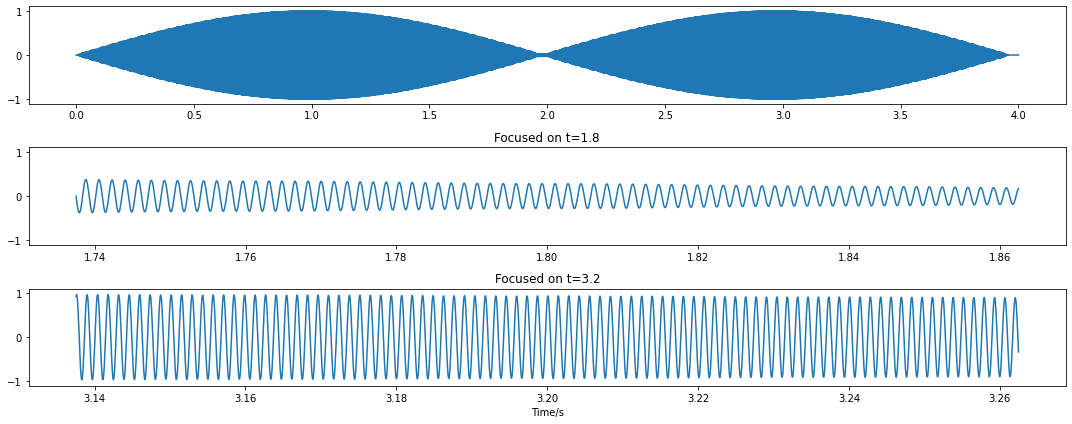

In [1]:
%load_ext autoreload
%autoreload 2

# Extract some f0
from ddsp.synths import BasicUpsampler
import numpy as np
from matplotlib import pyplot as plt
from ddsp.colab.jupyter_utils import show_audio

sample_rate = 16000
n_samples = 4*sample_rate
synth = BasicUpsampler(n_samples)

f0_hz = np.linspace(400, 800, 100).reshape([1,-1,1])
amplitudes = np.abs(np.sin(np.linspace(0, 2*np.pi, 100))).reshape([1,-1,1])

wav = synth.get_signal(amplitudes, f0_hz)
show_audio(wav, focus_points=[0.45, 0.8], focus_windows=[2000, 2000])

## Timbre Painting

In [6]:
from ddsp.training.decoders import TimbrePaintingDecoder

decoder = TimbrePaintingDecoder(name='tpd', input_keys=('amplitudes', 'f0_hz'))
batch = {
    'f0_hz': f0_hz,
    'amplitudes': amplitudes
}
controls = decoder(batch)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



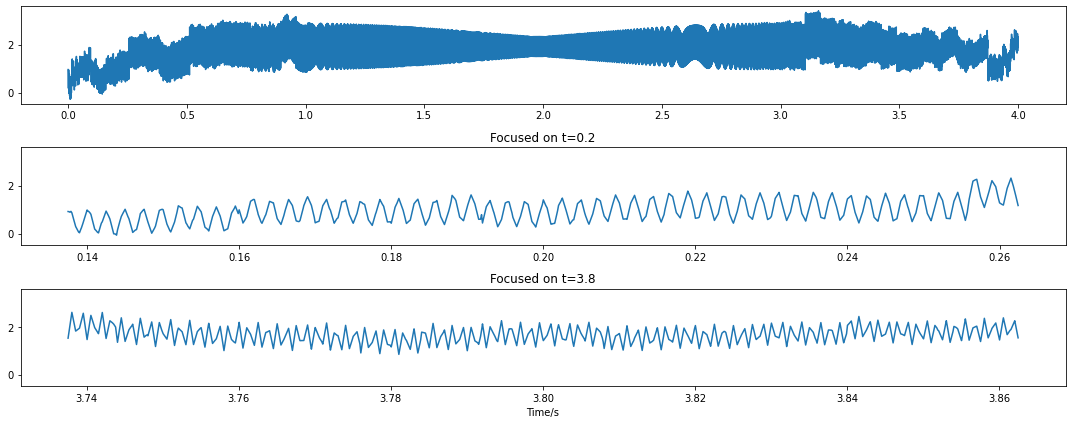

In [7]:
wav = controls['audio'].numpy().squeeze()
show_audio(wav, focus_points=[0.05, 0.95], focus_windows=[2000, 2000])

## Discriminator

In [11]:
!pip install tensorflow_addons

     |████████████████████████████████| 613 kB 1.2 MB/s eta 0:00:01


In [21]:
from ddsp.training import discriminator

critic = discriminator.ParallelWaveGANDiscriminator()

critic_score = critic(controls['audio'])

critic_score

AttributeError: 'int' object has no attribute 'lower'

## Check how scaling affects the result

Should scaling be used if f0 is the output of CREPE?

In [ ]:
plt.plot(synth.scale_fn(np.arange(-10, 30.5, 1)))

In [ ]:
wav_with_scaling = synth(amplitudes, f0_hz)
show_audio(wav_with_scaling, focus_points=[0.45, 0.8], focus_windows=[2000, 2000])

In [ ]:
# feed the outputs to crepe and see, which recovers f0_hz



# Shapes bla

In [ ]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers)
# from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = 16000
play = show_audio

In [ ]:
!mkdir ~/ddsp_data

In [ ]:
pwd

In [ ]:
!ls ../../../data/train.tfrecord*

In [ ]:
amplitudes.shape

In [ ]:
batch = {
    'audio': np.random.rand(2, 64000),
    'f0_hz': np.zeros([2, 1000]),
    'f0_confidence': np.random.rand(2, 1000),
    'loudness_db': np.random.rand(2, 1000)
}

play(batch['audio'][0])

## DDSP Decoder

In [ ]:
TIME_STEPS = 1000
strategy = train_util.get_strategy()

# Create Neural Networks.
preprocessor = preprocessing.DefaultPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                input_keys = ('ld_scaled', 'f0_scaled'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
additive = ddsp.synths.Additive(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='additive')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(additive, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'additive/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
    # Put it together in a model.
    model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
    trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)

In [ ]:
controls = model(batch)
controls.keys()

In [ ]:
for k in controls['inputs'].keys():
    print(k, (controls['inputs'][k]==controls[k]).numpy().all())

In [ ]:
controls['f0_hz'].shape

In [ ]:
output_splits=(('audio', 1),)
sum([v[1] for v in output_splits])